We have multiple variables hence we coin the term multivariate, for that we need some multivariate dataset
here we would be using General Electric Company's stock price historical data where the variables would be open, high, low, close and adj close stock price data to predict the opening price. Here, we would be fitting a LSTM for forecasting the opening price using multiple variables, hence the name Multivariate Timeseries analysis using LSTM networks.

One may also use these variables (open, high, low, closing and adj close) to predict any other vairable (like I choose to predict opening price of the stock).

Assumption: would be that the variables we choose affect the stock price

# Importing dataset and libraries

In [33]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from keras.models import Sequential # used to put our layers together
from keras.layers import LSTM
from keras.layers import Dense, Dropout
from sklearn.preprocessing import StandardScaler

In [34]:
# I have choosen a time period of 5yrs, from Dec-06-2018 to Dec-06-2023
df=pd.read_csv('GE.csv')

In [35]:
df

,Date,Open,High,Low,Close,Adj Close,Volume
0,2018-12-06,43.235455,44.376389,42.935207,44.136192,43.250275,18812178
1,2018-12-07,43.835945,44.316338,41.974419,42.094517,41.249584,19064371
2,2018-12-10,41.854321,42.755058,40.533237,41.614124,40.778843,18791545
3,2018-12-11,42.274666,42.815109,39.992794,40.593285,39.778484,20746407
4,2018-12-12,41.073681,42.214615,40.232990,40.293041,39.484268,17622205
...,...,...,...,...,...,...,...
1253,2023-11-29,119.519997,119.699997,118.449997,118.860001,118.860001,3027000
1254,2023-11-30,119.050003,121.839996,118.900002,121.800003,121.800003,8120200
1255,2023-12-01,121.699997,123.250000,121.470001,122.500000,122.500000,4523300
1256,2023-12-04,121.809998,122.410004,121.160004,121.529999,121.529999,3788600


In [36]:
df.head()

,Date,Open,High,Low,Close,Adj Close,Volume
0,2018-12-06,43.235455,44.376389,42.935207,44.136192,43.250275,18812178
1,2018-12-07,43.835945,44.316338,41.974419,42.094517,41.249584,19064371
2,2018-12-10,41.854321,42.755058,40.533237,41.614124,40.778843,18791545
3,2018-12-11,42.274666,42.815109,39.992794,40.593285,39.778484,20746407
4,2018-12-12,41.073681,42.214615,40.232990,40.293041,39.484268,17622205


Above we see how the data is framed and what are its columns

In [37]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1258 entries, 0 to 1257
Data columns (total 7 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   Date       1258 non-null   object 
 1   Open       1258 non-null   float64
 2   High       1258 non-null   float64
 3   Low        1258 non-null   float64
 4   Close      1258 non-null   float64
 5   Adj Close  1258 non-null   float64
 6   Volume     1258 non-null   int64  
dtypes: float64(5), int64(1), object(1)
memory usage: 68.9+ KB


We see that there are 1258 entries (which is basically number_of_trading days in a year x 5)
Number of trading days in a year is (250-252)

In [38]:
# now we separate the dates for future plotting
train_dates=pd.to_datetime(df['Date']) # X-axis in plotting

In [39]:
train_dates

0      2018-12-06
1      2018-12-07
2      2018-12-10
3      2018-12-11
4      2018-12-12
          ...    
1253   2023-11-29
1254   2023-11-30
1255   2023-12-01
1256   2023-12-04
1257   2023-12-05
Name: Date, Length: 1258, dtype: datetime64[ns]

<Axes: >

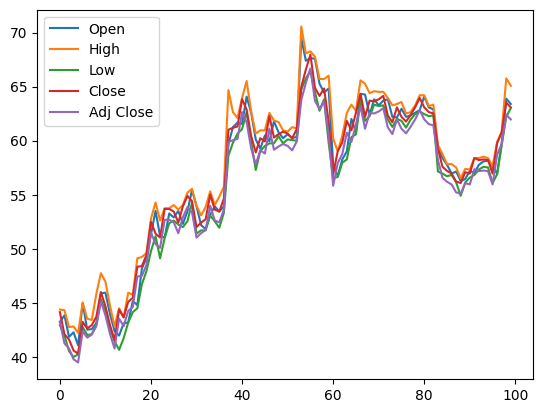

In [40]:
# variables for training
cols=list(df)[1:6] # columns used as variables, we have excluded volumnes here
df_for_training=df[cols].astype(float) #we convert them to float, so as to not loose any information while doing normalization

df_for_plot=df_for_training.head(100) #last 100 data points
df_for_plot.plot.line()

<Axes: >

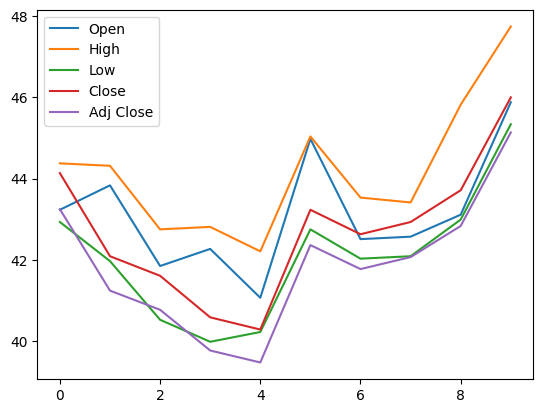

In [41]:
# variables for training
cols=list(df)[1:6] # columns used as variables, we have excluded volumnes here
df_for_training=df[cols].astype(float) #we convert them to float, so as to not loose any information while doing normalization

df_for_plot=df_for_training.head(10) #first 10 data points
df_for_plot.plot.line()

It also shows us an important detail that Adj Close and Close are not the same, more on this later.

# Preparing the data for modelling

As LSTMs use sigmoid and tanh as activation functions, which are sensitive to magnitude so values of the variables choosen needs to be normalised

Note: although they are very close to each other, as there isn't much variation in them in 1 day. Still it's a good practice to normalize them, also we have to keep in mind that the predicted values needs to be re transform via inverese transform as we have initially transformed them for analysis.

In [42]:
# Normalizing the dataset
scaler= StandardScaler() # here we create an object (instance)
scaler=scaler.fit(df_for_training) # we used all columns for fitting
df_for_training_scaled=scaler.transform(df_for_training)

AS LSTM networks, require to reshape an input data into n_samples x timestamps, and in this example the n_features is 2, we will make the timestamps=3. So the resultant n_samples is 5 (as the input data has 9 columns)

In [43]:
trainX=[] # training series ( time series )
trainY=[] # prediction

n_future=1 # number of days we want to predict into future
n_past=21 # number of days we want to use to predict the future

# like our X values would be the 21 values, and the 22nd value would be our Y and we would keep in in trainY

n_future and n_past can be changed and the value of n_past choosen depends on the type of trading u want to do. More on this later.

In [44]:
for i in range(n_past, len(df_for_training_scaled)-n_future+1):
    trainX.append(df_for_training_scaled[i-n_past : i, 0 : df_for_training.shape[1]])
    trainY.append(df_for_training_scaled[i+n_future-1 :i+n_future, 0])

trainX, trainY = np.array(trainX), np.array(trainY) # convert the lists into arrays

In [45]:
trainX # each of these would go to our LSTM as a training vector

array([[[-1.35253276, -1.3426084 , -1.31870256, -1.3062411 ,
         -1.31288661],
        [-1.32284772, -1.34556974, -1.36620824, -1.4070011 ,
         -1.41095964],
        [-1.42080869, -1.42256217, -1.43746676, -1.43070928,
         -1.43403516],
        ...,
        [-1.1091145 , -1.10274739, -1.13164909, -1.09583054,
         -1.1048883 ],
        [-1.05864979, -1.08497978, -1.07226699, -1.04545061,
         -1.0557848 ],
        [-0.95178316, -0.92803368, -0.98022472, -0.89431067,
         -0.90847268]],

       [[-1.32284772, -1.34556974, -1.36620824, -1.4070011 ,
         -1.41095964],
        [-1.42080869, -1.42256217, -1.43746676, -1.43070928,
         -1.43403516],
        [-1.40002907, -1.41960084, -1.46418869, -1.48108936,
         -1.48307234],
        ...,
        [-1.05864979, -1.08497978, -1.07226699, -1.04545061,
         -1.0557848 ],
        [-0.95178316, -0.92803368, -0.98022472, -0.89431067,
         -0.90847268],
        [-0.84491672, -0.85400258, -0.91193525, 

In [46]:
trainX.shape

(1237, 21, 5)

here the 21 is the 21 days we are looking at, and 5 is the number of variables we have choosen

In [47]:
trainY

array([[-0.84491672],
       [-0.96068877],
       [-0.96662577],
       ...,
       [ 2.52633774],
       [ 2.5317756 ],
       [ 2.49222805]])

In [48]:
trainY.shape

(1237, 1)

In [115]:
# define Autoencoder model

model = Sequential()
model.add(LSTM(64, activation='relu', input_shape=(trainX.shape[1], trainX.shape[2]), return_sequences=True))
# we did return_sequences as True, as we want the first LSTM to return a sequence upon which our 2nd LSTM can work
model.add(LSTM(32, activation='relu', return_sequences=False)) # its returning a vector and not a sequence
model.add(Dropout(0.2)) # regularisation and for avoiding overfitting
model.add(Dense(trainY.shape[1]))

model.compile(optimizer='adam', loss='mse')

In [116]:
model.summary()

Model: "sequential_9"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_16 (LSTM)              (None, 21, 64)            17920     
                                                                 
 lstm_17 (LSTM)              (None, 32)                12416     
                                                                 
 dropout_4 (Dropout)         (None, 32)                0         
                                                                 
 dense_4 (Dense)             (None, 1)                 33        
                                                                 
Total params: 30369 (118.63 KB)
Trainable params: 30369 (118.63 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [117]:
# Fit model
history=model.fit(trainX, trainY, epochs=15, batch_size=12, validation_split=0.15, verbose=1)

Epoch 1/15
88/88 [==============================] - 8s 33ms/step - loss: 0.1094 - val_loss: 2.4660
Epoch 2/15
88/88 [==============================] - 2s 24ms/step - loss: 0.0406 - val_loss: 140.4405
Epoch 3/15
88/88 [==============================] - 2s 22ms/step - loss: 0.0351 - val_loss: 1.1915
Epoch 4/15
88/88 [==============================] - 2s 22ms/step - loss: 0.0289 - val_loss: 0.5381
Epoch 5/15
88/88 [==============================] - 2s 23ms/step - loss: 0.0303 - val_loss: 0.8853
Epoch 6/15
88/88 [==============================] - 2s 26ms/step - loss: 0.0230 - val_loss: 2.1120
Epoch 7/15
88/88 [==============================] - 2s 26ms/step - loss: 0.0219 - val_loss: 0.3137
Epoch 8/15
88/88 [==============================] - 2s 25ms/step - loss: 0.0198 - val_loss: 0.6495
Epoch 9/15
88/88 [==============================] - 2s 25ms/step - loss: 0.0193 - val_loss: 0.3953
Epoch 10/15
88/88 [==============================] - 2s 25ms/step - loss: 0.0199 - val_loss: 0.0404
Epoch 1

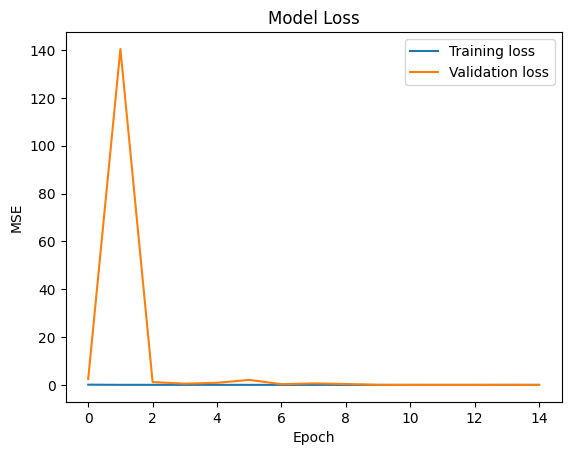

In [118]:
plt.plot(history.history['loss'], label='Training loss')
plt.plot(history.history['val_loss'], label='Validation loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('MSE')
plt.legend()

In [119]:
# forecasting
# start with the last day for training data and predict into future
n_future=90 # redefining n_future to extend prediction dates
forecast_period_dates=pd.date_range(list(train_dates)[-1], periods=n_future, freq='1d').tolist()

forecast=model.predict(trainX[-n_future:]) # forecast

# performimg inverse transforming to rescale back to original range
forecast_copies=np.repeat(forecast, df_for_training.shape[1], axis=-1) # shape is 5
y_pred_future=scaler.inverse_transform(forecast_copies)[:,0]

3/3 [==============================] - 1s 11ms/step


In [120]:
# convert timestamp to date
forecast_dates=[]
for time_i in forecast_period_dates:
    forecast_dates.append(time_i.date())

df_forecast=pd.DataFrame({'Date': np.array(forecast_dates), 'Open':y_pred_future}) # into single dataframe, date and opening values
df_forecast['Date']=pd.to_datetime(df_forecast['Date']) # datetime format

In [121]:
original=df[['Date','Open']]
original['Date']=pd.to_datetime(original['Date']) # do the same with original data
original=original.loc[original['Date'] >='2023-5-1']

C:\Users\HP\AppData\Local\Temp\ipykernel_5976\3555657690.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  original['Date']=pd.to_datetime(original['Date']) # do the same with original data


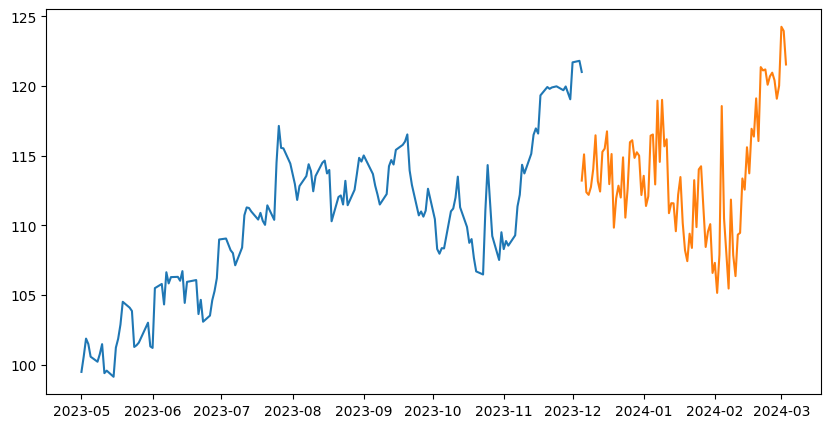

In [122]:
plt.figure(figsize=(10,5))
plt.plot(original['Date'],original['Open'])
plt.plot(df_forecast['Date'], df_forecast['Open'])
plt.show()

We are restricting to a tiny time period for better visualisation, orelse it would be cluttersome.